In [151]:
!apt-get install python3-pip

'apt-get' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [152]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [153]:
!python3 -V

Python 3.13.1


In [154]:
import torch
from torchvision import datasets
import torchvision.transforms as T

In [155]:
training_dataset_without_normalized = datasets.MNIST(
    root='data',
    train=True, 
    download=True,
    transform=T.ToTensor()
    )

test_dataset_without_normalized = datasets.MNIST(
    root='data',
    train=False, 
    download=True,
    transform=T.ToTensor()
    )

In [156]:
from torch.utils.data import ConcatDataset

mean, std = 0, 0

combined_data = ConcatDataset([training_dataset_without_normalized, test_dataset_without_normalized])

for image, label in combined_data:
  image = image.view(28 * 28)
  mean += image.mean().sum()
  std += image.std().sum()

mean /= len(combined_data)
std /= len(combined_data)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: 0.13092496991157532
Std: 0.30183959007263184


In [157]:
training_dataset = datasets.FashionMNIST(
    root='data',
    train=True, 
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
    )

test_dataset = datasets.FashionMNIST(
    root='data',
    train=False, 
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
    )

In [158]:
import matplotlib.pyplot as plt

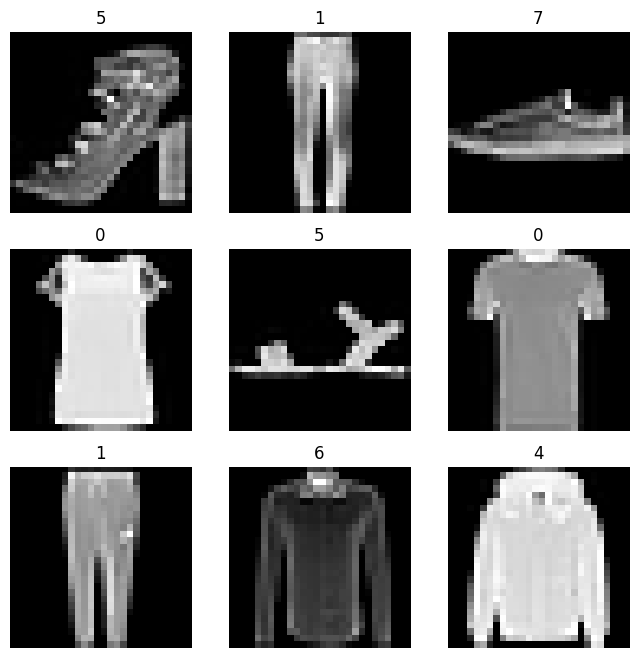

In [159]:

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [160]:
print(training_dataset)
print(training_dataset.data.shape)
print(training_dataset.targets.shape)
print(training_dataset.targets.unique())
print(training_dataset.targets.bincount())

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.13092496991157532, std=0.30183959007263184)
           )
torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])


In [161]:
from torch.utils.data import DataLoader

batch_size = 128 # multiple de 2 

train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f'Shape X , {X.shape}')
    print(f'Shape y: , {y.shape}')
    break

Shape X , torch.Size([128, 1, 28, 28])
Shape y: , torch.Size([128])


In [162]:
epochs = 10


In [163]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

input_dim = 28*28
output_dim = 10 #Nombre de classe
model = MLP([input_dim, 128, 128, output_dim]).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) 

using cuda


In [164]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [165]:

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist_experiment_1')
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

# Training loop with added graphing
def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, train_accuracy = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        print('train_loss:', train_loss)
        print('train accuracy:', train_accuracy)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_accuracy}, epoch)

        # Test the model
        test_loss, test_accuracy = test_loop(dataloader_test, model, loss_fn)
        print('test_loss:', test_loss)
        print('test accuracy:', test_accuracy)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': test_accuracy}, epoch)

        print(f"Epoch {epoch+1}/{epochs} complete\n")


In [166]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [167]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), #1 * 28 * 28 -> #32 * 28 * 28
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), #32 * 28 * 28 -> 64 * 28 * 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) #64 * 28 *28 -> 64 * 14 * 14
        )
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        x = self.conv_stack(x)
        x = self.mlp(x)
        return x

In [168]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-3) 

writer = SummaryWriter('runs/mnist_experiment_3')
train_and_test(train_dataloader, test_dataloader, cnn, loss_fn, optimizer, epochs, batch_size)


Epoch 1/10
train_loss: 0.41835417889201565
train accuracy: 84.69666666666666
test_loss: 0.2958174838295466
test accuracy: 89.25999999999999
Epoch 1/10 complete

Epoch 2/10
train_loss: 0.25475926214316763
train accuracy: 90.66
test_loss: 0.2706930250683917
test accuracy: 90.24
Epoch 2/10 complete

Epoch 3/10
train_loss: 0.20120261456253433
train accuracy: 92.55833333333334
test_loss: 0.23147082913525496
test accuracy: 91.35
Epoch 3/10 complete

Epoch 4/10
train_loss: 0.1632605799749843
train accuracy: 93.875
test_loss: 0.22752961290033558
test accuracy: 91.78
Epoch 4/10 complete

Epoch 5/10
train_loss: 0.1319285078502413
train accuracy: 95.08166666666666
test_loss: 0.2422804032699971
test accuracy: 91.72
Epoch 5/10 complete

Epoch 6/10
train_loss: 0.10489396406198616
train accuracy: 96.03666666666668
test_loss: 0.2346327550992181
test accuracy: 92.39
Epoch 6/10 complete

Epoch 7/10
train_loss: 0.07989930880984772
train accuracy: 97.10333333333332
test_loss: 0.25523233611749696
test accu

In [169]:
pip install onnx


Note: you may need to restart the kernel to use updated packages.


In [170]:
pip install onnxscript

Note: you may need to restart the kernel to use updated packages.


In [171]:
cnn.to('cpu')
torch_input = torch.rand(1, 1, 28, 28) # N, C, L, T
onxx_program = torch.onnx.export(
    cnn,
    torch_input,
    'model.onnx',
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    opset_version=11,
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

In [172]:
pip install onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [173]:
import onnxruntime

onnx_input = [torch_input]
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

ort_session = onnxruntime.InferenceSession("./model.onnx", provider_options={'device':'CPU'})

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

# onnxruntime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

Input length: 1
Sample input: [tensor([[[[0.8092, 0.8530, 0.8108, 0.8275, 0.7356, 0.1622, 0.9411, 0.2531,
           0.3713, 0.3520, 0.9566, 0.9944, 0.8791, 0.5532, 0.0265, 0.8871,
           0.9117, 0.4856, 0.7828, 0.5875, 0.5388, 0.9715, 0.3242, 0.5242,
           0.7579, 0.1070, 0.2972, 0.1510],
          [0.3952, 0.6958, 0.4350, 0.5678, 0.4049, 0.1881, 0.6636, 0.8802,
           0.6791, 0.9138, 0.3670, 0.8074, 0.9375, 0.5438, 0.5530, 0.7687,
           0.6835, 0.5156, 0.1928, 0.2457, 0.7261, 0.8130, 0.6693, 0.4976,
           0.4662, 0.1092, 0.8388, 0.7938],
          [0.7373, 0.8845, 0.6623, 0.6523, 0.1671, 0.5707, 0.5963, 0.9893,
           0.9056, 0.2841, 0.9087, 0.1797, 0.8550, 0.5252, 0.8606, 0.9198,
           0.6602, 0.1476, 0.1937, 0.1674, 0.3274, 0.7276, 0.9182, 0.4324,
           0.0772, 0.6370, 0.3774, 0.9275],
          [0.2547, 0.2547, 0.5008, 0.2488, 0.0379, 0.3849, 0.2496, 0.1405,
           0.0786, 0.5735, 0.0097, 0.1461, 0.1663, 0.3535, 0.3053, 0.4659,
           0